In [84]:
import pypylon.pylon as py
import pypylon.genicam as geni
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import pandas as pd

# Hardware triggering Basler ace acA1920-155uc

<div>
<img src="attachment:image-2.png" align="center" width="500"/>
</div>

The HW trigger unit is a simple RasperryPi generating 5Hz Signal on it's GPIO

In [85]:
# open the camera
tlf = py.TlFactory.GetInstance()
cam = py.InstantCamera(tlf.CreateFirstDevice())
cam.Open()

# first quick check of our input signal

* most Basler cameras have chunk feature ( image meta-data transport)
* one of the chunks is 'LineStatusAll' 
* that samples all IO lines on FrameStart

In [86]:
# sample the io state with max possible framerate and chunks

In [87]:
# enable the chunk that
# samples all IO lines on every FrameStart
cam.ChunkModeActive.Value = True
cam.ChunkSelector.Value = "LineStatusAll"
cam.ChunkEnable.Value = True

In [88]:
cam.ChunkSelector.Symbolics

('AutoBrightnessStatus',
 'CounterValue',
 'ExposureTime',
 'FrameID',
 'Gain',
 'LineStatusAll',
 'PayloadCRC16',
 'SequencerSetActive',
 'Timestamp')

In [109]:
# Select Line 2 (output line)
cam.LineSelector.Value = "Line2"
cam.LineMode.Value = "Output"
# Select the Exposure Active signal as the source signal for Line 2
cam.LineSource.Value = "FlashWindow"

# Select GPIO line 3
cam.LineSelector.Value = "Line3"
# Set the line mode to Input
cam.LineMode.Value = "Input"

In [110]:
# set max speed
cam.Height.SetValue(cam.Height.Min)
cam.Width.SetValue(cam.Width.Min)
# cam.ExposureTime.SetValue(cam.ExposureTime.Min)
cam.ExposureTime.SetValue(5000)

In [111]:
print(cam.ResultingFrameRate.Value)
cam.StartGrabbingMax(1000)

io_res = []
while cam.IsGrabbing():
    with cam.RetrieveResult(1000) as res:
        time_stamp = res.TimeStamp
        io_res.append((time_stamp, res.ChunkLineStatusAll.Value))
        
cam.StopGrabbing()


198.4126984126984


In [112]:
# list of timestamp + io status
io_res[:10]

[(180510091620, 0),
 (180515131690, 0),
 (180520171760, 0),
 (180525211830, 0),
 (180530251900, 0),
 (180535291970, 0),
 (180540332040, 0),
 (180545372110, 0),
 (180550412180, 0),
 (180555452250, 0)]

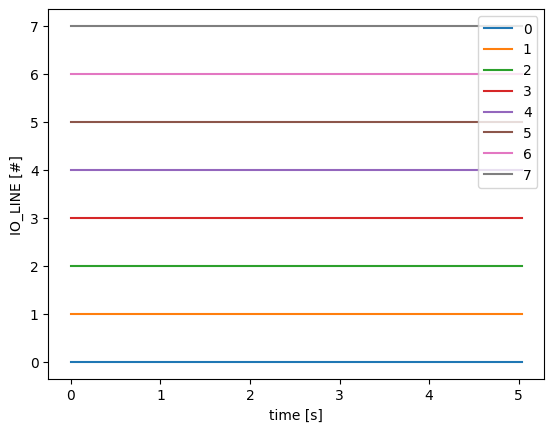

In [113]:
# simple logic analyzer :-)

# convert to numpy array
io_array = np.array(io_res)
# extract first column timestamps
x_vals = io_array[:,0]
#  start with first timestamp as '0'
x_vals -= x_vals[0]

# extract second column io values
y_vals = io_array[:,1]
# for each bit plot the graph
for bit in range(8):
    logic_level = ((y_vals & (1<<bit)) != 0)*0.8 +bit
    # plot in seconds
    plt.plot(x_vals / 1e9, logic_level, label = bit)
    
plt.xlabel("time [s]")
plt.ylabel("IO_LINE [#]")
plt.legend()
plt.show()

# Grabbing with Hardware Trigger on line4

In [77]:
# get clean powerup state
cam.UserSetSelector.Value = "Default"
cam.UserSetLoad.Execute()

setup the io section

In [78]:
cam.LineSelector.Value = "Line3"
cam.LineMode.Value = "Input"

setup the trigger / acquisition controls

In [79]:
cam.TriggerSelector.Value = "FrameStart"
cam.TriggerSource.Value = "Line3"
cam.TriggerMode.Value = "On"
cam.TriggerActivation.Value

'RisingEdge'

When trigger is already running we can just extend the grab-timeout to be larger than trigger rate

In [ ]:
res = cam.GrabOne(py.waitForever)

When the trigger could be off when you start or much longer, that you would want to wait ....

options are:

* call `cam.RetrieveResult(py.waitForever)`
  but this will block until a frame is received
* poll `cam.NumReadyBuffers.Value` to check if at least one frame is available
* use the pylon background loop to capture

## triggered acquisition using the background loop

In [80]:
# definition of event handler class 
class TriggeredImage(py.ImageEventHandler):
    def __init__(self):
        super().__init__()
        self.grab_times = []
    def OnImageGrabbed(self, camera, grabResult):
        self.grab_times.append(grabResult.TimeStamp)

In [81]:
# create event handler instance
image_timestamps = TriggeredImage()

# register handler
# remove all other handlers
cam.RegisterImageEventHandler(image_timestamps, 
                              py.RegistrationMode_ReplaceAll, 
                              py.Cleanup_None)

# start grabbing with background loop
cam.StartGrabbingMax(100, py.GrabStrategy_LatestImages, py.GrabLoop_ProvidedByInstantCamera)
# wait ... or do something relevant
while cam.IsGrabbing():
    time.sleep(0.1)
# stop grabbing
cam.StopGrabbing()

KeyboardInterrupt: 

In [ ]:
# let's check how precise the image acquisition was:
# assumption: the camera main oscillator has a much higher precision
#             than the raspberry-pi PWM output

# frame_delta = np.diff(np.array(image_timestamps.grab_times))/1e6

In [23]:
np.diff(image_timestamps.grab_times)

array([200200248, 200199141, 200173059, 200199843, 200171790, 200171547,
       200199681, 200199195, 200173005, 200199735, 200171898, 200166525,
       200171250, 200171169, 200201031, 200173113, 200171520, 200201571,
       200199330, 200172843, 200198493, 200167821, 200166390, 200226384,
       200183400, 200172114, 200174463, 200170818, 200169684, 200214261,
       200170980, 200168955, 200171817, 200168820, 200173005, 200175381,
       200214450, 200182482, 200171628, 200185101, 200180754, 200176623,
       200179539, 200173896, 200174706, 200168523, 200201220, 200169657,
       200199357, 200173356, 200168361, 200168118, 200167173, 200199762,
       200168361, 200181537, 200172357, 200168469, 200175921, 200170764,
       200168685, 200171574, 200172060, 200172600, 200172762, 200171979,
       200170845, 200204514, 200173140, 200167686, 200166363, 200198304,
       200175678, 200168415, 200167443, 200173599, 200198385, 200175840,
       200169414, 200197791, 200173518, 200168010, 

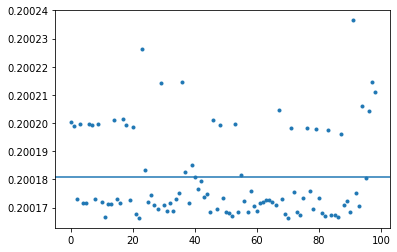

In [24]:
frame_delta_s = np.diff(np.array(image_timestamps.grab_times))/1.e9
plt.plot(frame_delta_s, ".")
plt.axhline(np.mean(frame_delta_s))

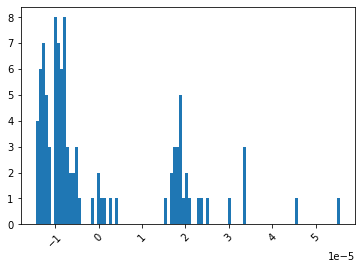

In [25]:
plt.hist(frame_delta_s  - np.mean(frame_delta_s) , bins=100)
plt.xticks(rotation=45)
plt.show()

In [27]:
cam.Close()